# Modelo VAR

Os modelos de vetores autorregressivos se diferem dos modelos AR, ARMA e ARIMA por não serem unidirecionais, isto é, as variáveis preditivas e _target_ se influenciam em ambos os sentidos.

Os modelos VAR costumam ser escritos matematicamente em forma de matriz. Uma equação VAR de grau $p$ com $k$ séries corresponde a:

$$
\begin{bmatrix}
y_1\\
y_2\\
.\\
.\\
y_k
\end{bmatrix}
=
\begin{bmatrix}
c_1\\
c_2\\
.\\
.\\
c_k
\end{bmatrix}
+
\begin{bmatrix}
\phi_{11} & . & . & \phi_{1p}\\
\phi_{21} & . & . & \phi_{2p}\\
. & . & . & .\\
. & . & . & .\\
\phi_{k1} & . & . & \phi_{kp}
\end{bmatrix}
\begin{bmatrix}
y_{1, t-1}\\
y_{2, t-1}\\
.\\
.\\
y_{k, t-1}
\end{bmatrix} + \cdots + 
\begin{bmatrix}
\phi_{11} & . & . & \phi_{1p}\\
\phi_{21} & . & . & \phi_{2p}\\
. & . & . & .\\
. & . & . & .\\
\phi_{k1} & . & . & \phi_{kp}
\end{bmatrix}
\begin{bmatrix}
y_{1, t-p}\\
y_{2, t-p}\\
.\\
.\\
y_{k, t-p}
\end{bmatrix} +
\begin{bmatrix}
\epsilon_1\\
\epsilon_2\\
.\\
.\\
\epsilon_k
\end{bmatrix}
$$

## Modelo VARMA

Seria similar ao modelo ARMA, mas com implementação em vetores para múltiplas séries.

## Modelos VAR/VARMA em Python

Serão utilizados dois *datasets* do [Kaggle](https://www.kaggle.com/datasets/prakharprasad/time-series-data-1?select=M2SLMoneyStock.csv), que serão combinados, resultando em um único *dataset* com dados mensais de Janeiro/1995 a Dezembro/2015.

Lista de passos

- Análise Exploratória dos Dados
- Testar para estacionariedade
    - Se não for estacionária, tirar a diferença em grau 1
    - Repetir até ter dados estacionários
- Dividir em dados de treino e teste
- Testar a ordem P
- Aplicar modelo com a ordem P
- Realizar previsões nos dados de teste
- Se necessário, desfazer a transformação do começo

## Análise Exploratória dos Dados

### Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pmdarima import auto_arima
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

import warnings
warnings.filterwarnings("ignore")

In [2]:
money_df = pd.read_csv('dados/M2SLMoneyStock.csv', 
                       dtype={'Money':'float'}, 
                       index_col=0, 
                       parse_dates=True)
spending_df = pd.read_csv('dados/PCEPersonalSpending.csv', 
                          dtype={'Spending':'float'},
                         index_col=0, 
                       parse_dates=True)
df = money_df.join(spending_df, on='Date')
df.index.freq = 'MS'

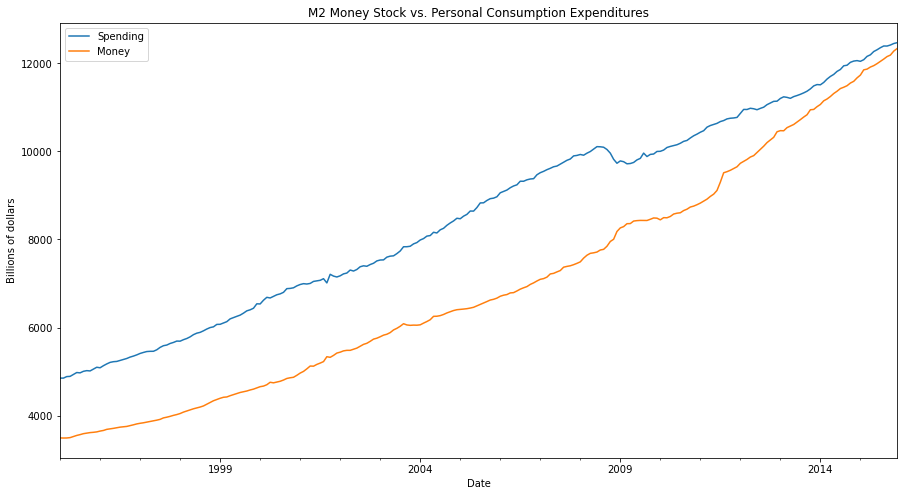

In [3]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel= 'Billions of dollars'
xlabel= ''

ax = df['Spending'].plot(figsize=(15,8),
                         title=title,
                         legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

### Curiosidade econômica

M2 é um agregado monetário que corresponde ao M1 (papel moeda em poder do público + depósitos à vista) somado aos depósitos a prazo (depósitos para investimentos, depósitos de poupança, fundos de aplicação financeira e de renda fixa de curto prazo) + títulos do governo em poder do público.

Os agregados monetários vão até M5, e cada nível possui menos liquidez que o anterior 

In [4]:
def dickey_fuller(series,title='df'):
    '''Teste de Hipótese para estacionariedade'''
    print(f'Augmented Dickey Fuller Test for the dataset {title}')
    
    result = adfuller(series.dropna(),autolag='AIC')
    # use help(adfuller) to understand why these labels are chosen
    labels = ['ADF test statistics','p-value','#lags','#observations']
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    # this will not print the line 'dtype:float64'
    print(outcome.to_string())
    
    if result[1] <= 0.05:
        # H_0 é que os dados não são estacionários
        print('Strong evidence against the null hypothesis') 
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [5]:
dickey_fuller(df['Money'], 'M2')

Augmented Dickey Fuller Test for the dataset M2
ADF test statistics       4.239022
p-value                   1.000000
#lags                     4.000000
#observations           247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the Null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


In [6]:
dickey_fuller(df['Spending'], 'Gastos')

Augmented Dickey Fuller Test for the dataset Gastos
ADF test statistics       0.149796
p-value                   0.969301
#lags                     3.000000
#observations           248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the Null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


A análise gráfica já indicava isso, mas os testes confirmam: ambas as séries não são estacionárias.

In [7]:
df_diff1 = df.diff(1).dropna()
df_diff1.head()

,Money,Spending
Date,,
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9
1995-06-01,24.7,44.4


In [8]:
dickey_fuller(df_diff1['Money'], 'M2 diff')

Augmented Dickey Fuller Test for the dataset M2 diff
ADF test statistics      -2.057404
p-value                   0.261984
#lags                    15.000000
#observations           235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the Null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


In [9]:
dickey_fuller(df_diff1['Spending'], 'Gastos diff')

Augmented Dickey Fuller Test for the dataset Gastos diff
ADF test statistics    -7.226974e+00
p-value                 2.041027e-10
#lags                   2.000000e+00
#observations           2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [10]:
dickey_fuller(df['Money'].diff().diff().dropna(), 'M2 diff')

Augmented Dickey Fuller Test for the dataset M2 diff
ADF test statistics    -7.077471e+00
p-value                 4.760675e-10
#lags                   1.400000e+01
#observations           2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [11]:
dickey_fuller(df['Spending'].diff().diff().dropna(), 'Gastos diff')

Augmented Dickey Fuller Test for the dataset Gastos diff
ADF test statistics    -8.760145e+00
p-value                 2.687900e-14
#lags                   8.000000e+00
#observations           2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Com isso, temos os dados finais para a estacionariedade de cada série.

In [12]:
df_transformed = df.diff().diff().dropna()
df_transformed

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7
...,...,...
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8
2015-10-01,-23.1,24.5


In [13]:
df_transformed.shape

(250, 2)

## Divisão em treino e teste

In [14]:
n_obs = 12
train = df_transformed[0:-n_obs]
test = df_transformed[-n_obs:]

## Testar qual ordem $p$ é melhor

In [15]:
auto_arima(df['Money'],maxiter=1500)

ARIMA(maxiter=1500, order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [16]:
auto_arima(df['Spending'],maxiter=1500)

ARIMA(maxiter=1500, order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

Ou seja, o melhor seria a ordem 1 para $p$.

In [17]:
modelo_varma = VARMAX(train, order=(1, 2), trend='c')
results = modelo_varma.fit(maxiter=10_000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.305
,+ intercept,AIC,4606.610
Date:,"Sun, 14 Aug 2022",BIC,4665.638
Time:,03:14:46,HQIC,4630.399
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.63, 0.00",Jarque-Bera (JB):,"546.15, 111.91"
Prob(Q):,"0.43, 1.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.54, 2.94",Skew:,"1.32, -0.32"


## Realizar previsões no período de teste

In [18]:
df_forecast = results.forecast(n_obs)
df_forecast

,Money,Spending
2015-01-01,-11.339133,38.944118
2015-02-01,-11.101564,-5.103266
2015-03-01,0.564258,-0.255383
2015-04-01,-1.251545,-0.315606
2015-05-01,0.584348,0.267413
2015-06-01,-0.103866,0.109302
2015-07-01,0.289332,0.218508
2015-08-01,0.106902,0.171707
2015-09-01,0.200192,0.196615
2015-10-01,0.154668,0.184683


## Desfazer as transformações

In [19]:
df_forecast['Money1d'] = (df['Money'].iloc[-n_obs-1]-df['Money'].iloc[-n_obs-2]) + df_forecast['Money'].cumsum()
df_forecast['MoneyForecast'] = df['Money'].iloc[-n_obs-1] + df_forecast['Money'].cumsum()

In [20]:
df_forecast['Spending1d'] = (df['Spending'].iloc[-n_obs-1]-df['Spending'].iloc[-n_obs-2]) + df_forecast['Spending'].cumsum()
df_forecast['SpendingForecast'] = df['Spending'].iloc[-n_obs-1] + df_forecast['Spending'].cumsum()

In [21]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-11.339133,38.944118,67.260867,11658.760867,49.544118,12100.944118
2015-02-01,-11.101564,-5.103266,56.159303,11647.659303,44.440852,12095.840852
2015-03-01,0.564258,-0.255383,56.723562,11648.223562,44.185469,12095.585469
2015-04-01,-1.251545,-0.315606,55.472016,11646.972016,43.869863,12095.269863
2015-05-01,0.584348,0.267413,56.056364,11647.556364,44.137276,12095.537276
2015-06-01,-0.103866,0.109302,55.952498,11647.452498,44.246578,12095.646578
2015-07-01,0.289332,0.218508,56.241830,11647.741830,44.465086,12095.865086
2015-08-01,0.106902,0.171707,56.348732,11647.848732,44.636793,12096.036793
2015-09-01,0.200192,0.196615,56.548923,11648.048923,44.833408,12096.233408
2015-10-01,0.154668,0.184683,56.703591,11648.203591,45.018091,12096.418091


In [22]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
2015-01-01,11733.2,12046.0,11658.760867,12100.944118
2015-02-01,11852.4,12082.4,11647.659303,12095.840852
2015-03-01,11868.8,12158.3,11648.223562,12095.585469
2015-04-01,11916.1,12193.8,11646.972016,12095.269863
2015-05-01,11947.6,12268.1,11647.556364,12095.537276
2015-06-01,11993.1,12308.3,11647.452498,12095.646578
2015-07-01,12045.3,12355.4,11647.741830,12095.865086
2015-08-01,12096.8,12394.0,11647.848732,12096.036793
2015-09-01,12153.8,12392.8,11648.048923,12096.233408
2015-10-01,12187.7,12416.1,11648.203591,12096.418091


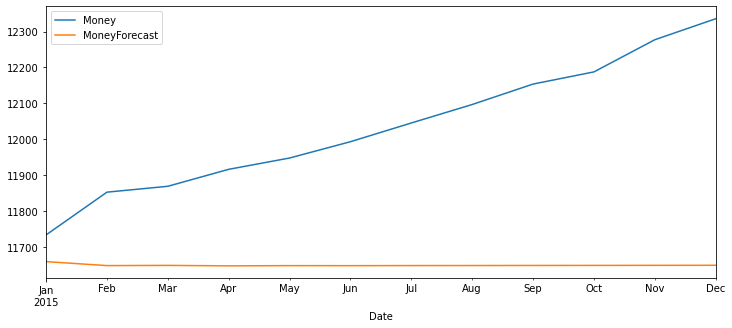

In [23]:
df['Money'][-n_obs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

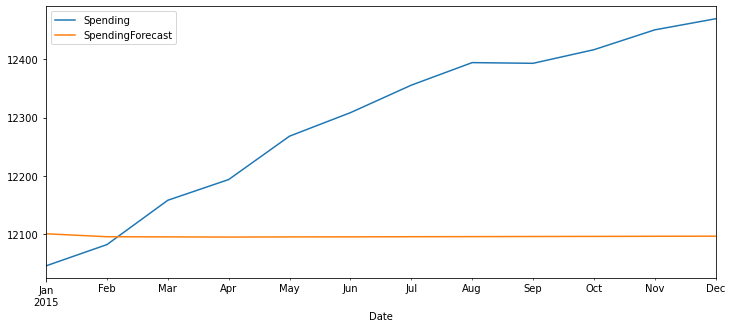

In [24]:
df['Spending'][-n_obs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

## Avaliação do Modelo

In [25]:
RMSE1 = rmse(df['Money'][-n_obs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 423.538


In [26]:
RMSE2 = rmse(df['Spending'][-n_obs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 241.815


O modelo VARMA teve péssima avaliação nestes dados. Talvez a cointegração não fosse boa ou as quebras do período (crises de 98/99, bolha.com e de 2008) interfiram nisso também.